In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [2]:
labels_df = pd.read_csv('labels.csv')

In [3]:
data_dir = '/content/drive/MyDrive/traffic_Data/DATA'
images = []
labels = []

In [4]:
for class_folder in os.listdir(data_dir):
    class_id = int(class_folder)
    class_path = os.path.join(data_dir, class_folder)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

        class_name = labels_df.loc[labels_df['ClassId'] == class_id, 'Name'].iloc[0]
        labels.append(class_name)

In [5]:
resized_images = []


In [6]:
resized_images = []
for img in images:
    resized_img = cv2.resize(img, (224, 224))
    resized_images.append(resized_img)

In [7]:
images = np.array(resized_images)
labels = np.array(labels)

In [8]:
print(images.shape , labels.shape)

(4170, 224, 224, 3) (4170,)


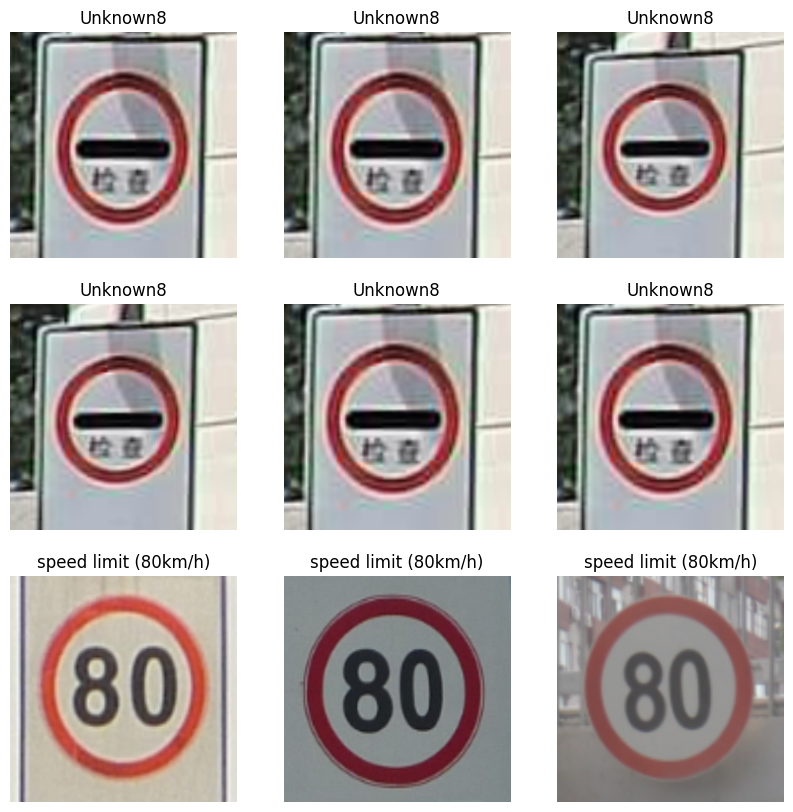

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model


base_model = MobileNetV2(weights='imagenet', include_top=False , input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(58, activation='softmax')(x)
mobilenet_model = Model(inputs=base_model.input, outputs=output)

In [15]:
mobilenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
mobilenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [17]:
X_resized = np.array(resized_images)

In [18]:
X_train_resized, X_test_resized, y_train, y_test = train_test_split(X_resized, labels, test_size=0.2, random_state=42)

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
label_encoder = LabelEncoder()


y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)



In [21]:
checkpoint_filepath = 'model_weights.h5'


checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [23]:
history = mobilenet_model.fit(X_train_resized, y_train_encoded,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test_resized, y_test_encoded),
                    callbacks=[checkpoint_callback])


test_loss, test_acc = mobilenet_model.evaluate(X_test_resized, y_test_encoded)
print("Test Accuracy:", test_acc)

Epoch 1/10
105/105 [==============================] - 664s 6s/step - loss: 0.6022 - accuracy: 0.8516 - val_loss: 23.4754 - val_accuracy: 0.0492
Epoch 2/10
105/105 [==============================] - 655s 6s/step - loss: 0.1715 - accuracy: 0.9538 - val_loss: 19.9983 - val_accuracy: 0.0767
Epoch 3/10
105/105 [==============================] - 658s 6s/step - loss: 0.1038 - accuracy: 0.9751 - val_loss: 12.5063 - val_accuracy: 0.0983
Epoch 4/10
105/105 [==============================] - 647s 6s/step - loss: 0.1642 - accuracy: 0.9583 - val_loss: 66.8068 - val_accuracy: 0.0408
Epoch 5/10
105/105 [==============================] - 664s 6s/step - loss: 0.0298 - accuracy: 0.9922 - val_loss: 47.4433 - val_accuracy: 0.0923
Epoch 6/10
105/105 [==============================] - 635s 6s/step - loss: 0.0492 - accuracy: 0.9874 - val_loss: 27.4959 - val_accuracy: 0.0875
Epoch 7/10
105/105 [==============================] - 642s 6s/step - loss: 0.0423 - accuracy: 0.9886 - val_loss: 12.6758 - val_accuracy:

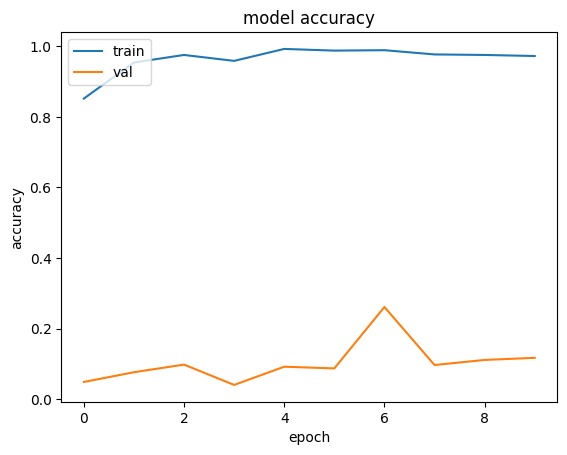

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

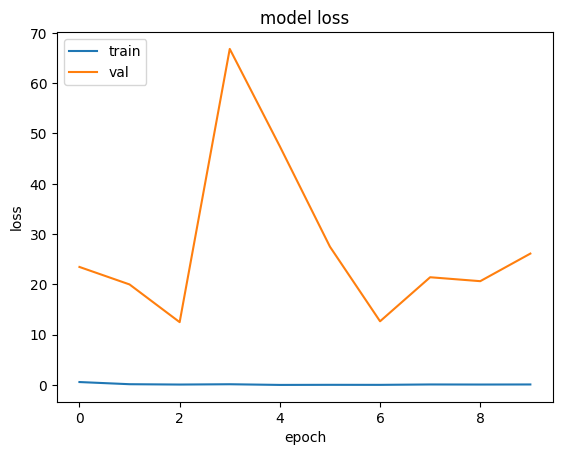

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

27/27 [==============================] - 31s 991ms/step


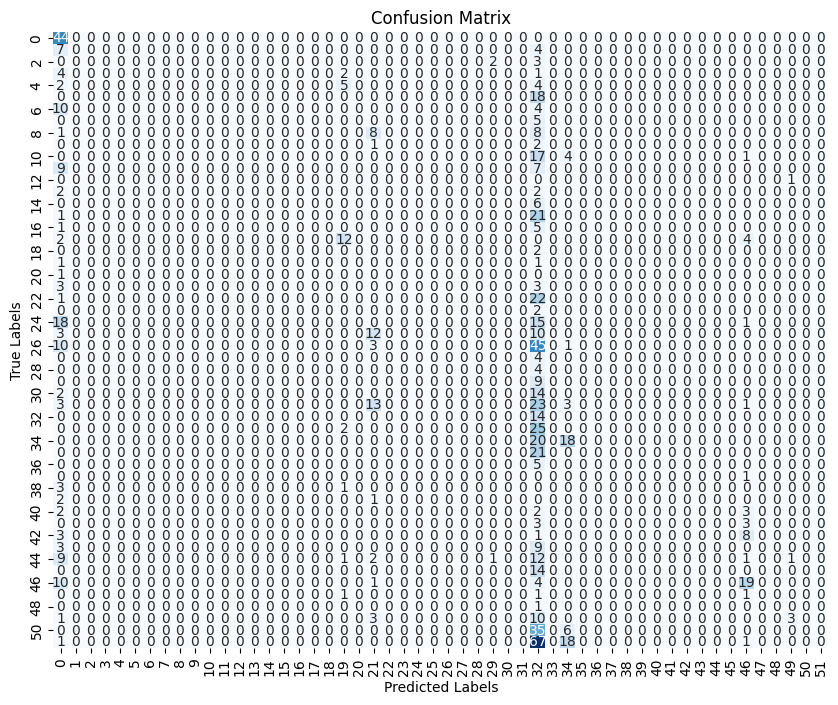

              precision    recall  f1-score   support

           0       0.28      1.00      0.43        44
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00        17
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00        22
          17       0.00      0.00      0.00         6
          18       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = mobilenet_model.predict(X_test_resized)

y_pred_labels = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test_encoded, y_pred_labels))